In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.insert(0, os.path.abspath('../code'))

from methods_time_integrals import find_Cdnod, plot_integrals, find_Rnod

## Calculating $\overline{C}$ with parametrized friction
The mumentum budget is given by
$$ 
\frac{\partial}{\partial t} \overline{C} + \oint \overline{\zeta}\overline{\mathbf{u}} \cdot \mathbf{n}\,dl + \oint \overline{\zeta'u'} \cdot \mathbf{n}\,dl = \oint \frac{\overline{{\tau}}_s}{\rho H}\cdot d\mathbf{l} - \oint \frac{\overline{{\tau}}_b}{H}\cdot d\mathbf{l}
$$

The friction in ROMS is defined as
$$
\overline{\tau}_b = C_d |u_b|\mathbf{u}_b,
$$
where $C_d = 0.003$. The contribution of the bottom drag to the momentum budget $T_b$ is thus
$$
T_b = \oint \frac{C_d |u_b|\mathbf{u}_b}{H}\cdot d\mathbf{l}.
$$.

As we saw in [Present_1.ipynb](Present_1.ipynb), we get a drifting problem when we integrate these terms directly in time. This is because we are not able to exactly close the momentum budget, and thus accumulate errors over time. Instead, we can parametrize the friction as dependent on $\overline{C}$, and calculate the bottom drag for every time step.

### Linear parametrization
We assume
$$
T_b = R\overline{C}
$$.
The circulation for the next time step can the be calculated as 
$$
\overline{C}_{i+1} = \overline{C}_{i} + dt*(F_i - R\overline{C_i})
$$
where 
$$
F = \oint \frac{\overline{{\tau}}_s}{\rho H}\cdot d\mathbf{l} - \oint \overline{\zeta}\overline{\mathbf{u}} \cdot \mathbf{n}\,dl - \oint \overline{\zeta'u'} \cdot \mathbf{n}\,dl.
$$

But what value should $R$ be? Comparing with the bottom drag in ROMS, we have
$$
R\overline{C} = \oint \frac{C_d |u_b|\mathbf{u}_b}{H}\cdot d\mathbf{l}
$$ 
which gives
$$
R = \oint \frac{C_d |u_b|\mathbf{u}_b}{H}\cdot d\mathbf{l} / \overline{C}
$$

Let's plot $R$ for Arctic4 and Lofoten800:

In [2]:
# Define the data path where datasets are stored
datapath = "../data/"

# Define the drag coefficient
dt = 60*60*24

H = 3114
rho = 1025
Cd = 0.003

# Define the filenames for the datasets 
A4_file = "A4/A4_lofoten_h_50km_timeseries.nc" 
L800_file = "lofoten800/lofoten800_lofoten_h_50km_timeseries.nc" 

# Load the datasets using xarray
ts_A4 = xr.open_dataset(datapath + A4_file)
ts_L800 = xr.open_dataset(datapath + L800_file).sel(ocean_time=slice("01.01.1997", None))

# Adjusting surface stress
ts_A4["taucirc_area"] = ts_A4.taucirc_area/(H*rho)

ts_L800["taucirc_area"] = ts_L800.taucirc_area/(H*rho)

# Combining the two vorticity terms
ts_L800["zflux_area"] = ts_L800.zbarflux_area + ts_L800.znodflux_area


# Interpolating missing values TODO : fill in data gaps
ts_L800["ucirc_area"] = ts_L800["ucirc_area"].interpolate_na(dim="ocean_time", method="linear")
#ts_L800["ub2circ"] = ts_L800["ub2circ"].interpolate_na(dim="ocean_time", method="linear")

sns.set_theme("notebook")

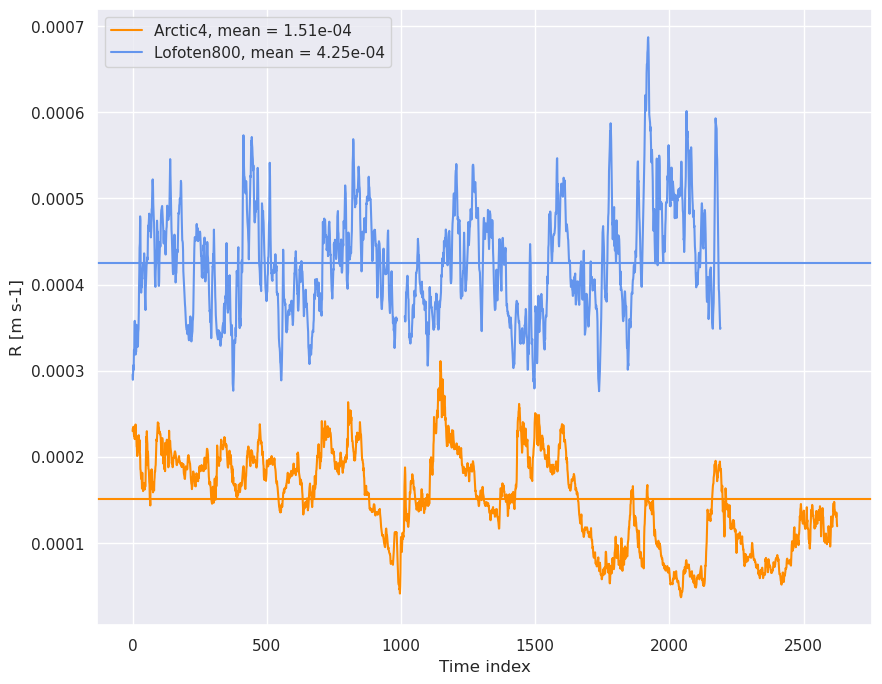

In [3]:
# Calculate the corrected drag coefficient (Cdnod) for each dataset
Rnod_A4 = find_Rnod(ts_A4, Cd)
Rnod_L800 = find_Rnod(ts_L800, Cd)

# calculate mean corrected drag coefficient
Rnod_A4_mean = np.nanmean(Rnod_A4)
Rnod_L800_mean = np.nanmean(Rnod_L800)

fig, ax = plt.subplots(figsize=(10,8))

# Plot the Cdnod for both datasets
ax.plot(Rnod_A4, label=f'Arctic4, mean = {Rnod_A4_mean:.2e}', color="darkorange")
ax.plot(Rnod_L800, label=f'Lofoten800, mean = {Rnod_L800_mean:.2e}', color="cornflowerblue")

# Add a horizontal line to represent the mean values
ax.axhline(Rnod_A4_mean, color="darkorange")
ax.axhline(Rnod_L800_mean, color="cornflowerblue")


# Add labels and a legend for better clarity
ax.set_xlabel('Time index')
ax.set_ylabel('R [m s-1]')
ax.legend()

fig.savefig("figures/adjustedR.pdf")
fig.savefig("figures/adjustedR.png")

We see that the mean $R$ has a higher value in Lofoten800, which makes sence since the circulation is stronger in this simulaiton. Also, $R$ seems to approximatley ossilate around a mean value.


Let's calculate time series of $\overline{C}$ using a linear friction parametrizatoin and the mean values for $R$ calculated above. 

We plot time series where only surface forcing is included as driving forces. This corresponds to a linear model.

We also plot time series where vorticity fluxes are included.

#### Arctic4 linear friction

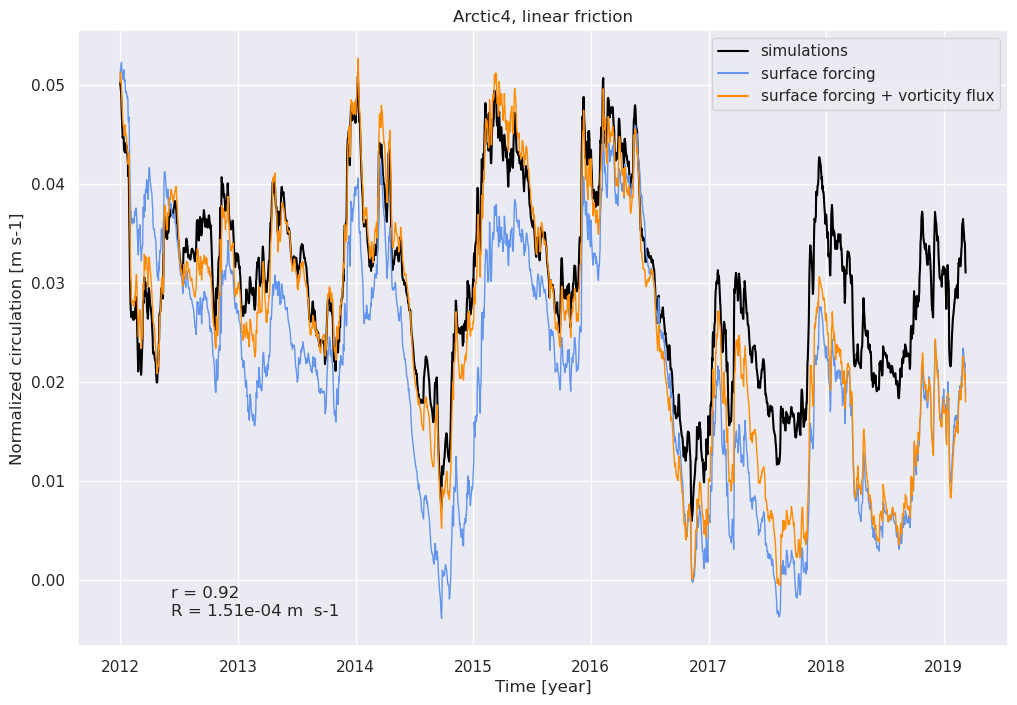

In [4]:
figA4, axA4, infoA4 = plot_integrals(ts_A4, friction="linear", 
                             #R=R
                             adjustR=True,
                             )
#axA4.set_title(f"Arctic4, linear friction R = {R:.1e}") 
axA4.set_title(f"Arctic4, linear friction")

r = infoA4["r"]
R = infoA4["Rnod"]
axA4.text(0.1, 0.05, f"r = {r:.2f}\nR = {R:.2e} m  s-1", transform=axA4.transAxes)

figA4.savefig("figures/A4_time_integral_adjusted_R.pdf")
figA4.savefig("figures/A4_time_integral_adjusted_R.png")

We see from the blue line that the linear model, only including wind, is quite sucsesfull in reproducing the circulation. However, there is a small offset between the black and blue line. 

Including vorticity fluxes decreases this offset, suggesting that vorticity fluxes does contribute to the circulation. The vorticity fluxes have a positive/cyclonic contribution, exept for the at very beginning of the time series. 

The difference between predictions (orange/blue curve) and simulations (black curve) increases towards the end of the time series. Going back to the plot above (showing R over time), we see that the optimal value for R seems to change towards the end of the time series, which might indicate that we have a regime shift. 

#### Lofoten800 linear friction

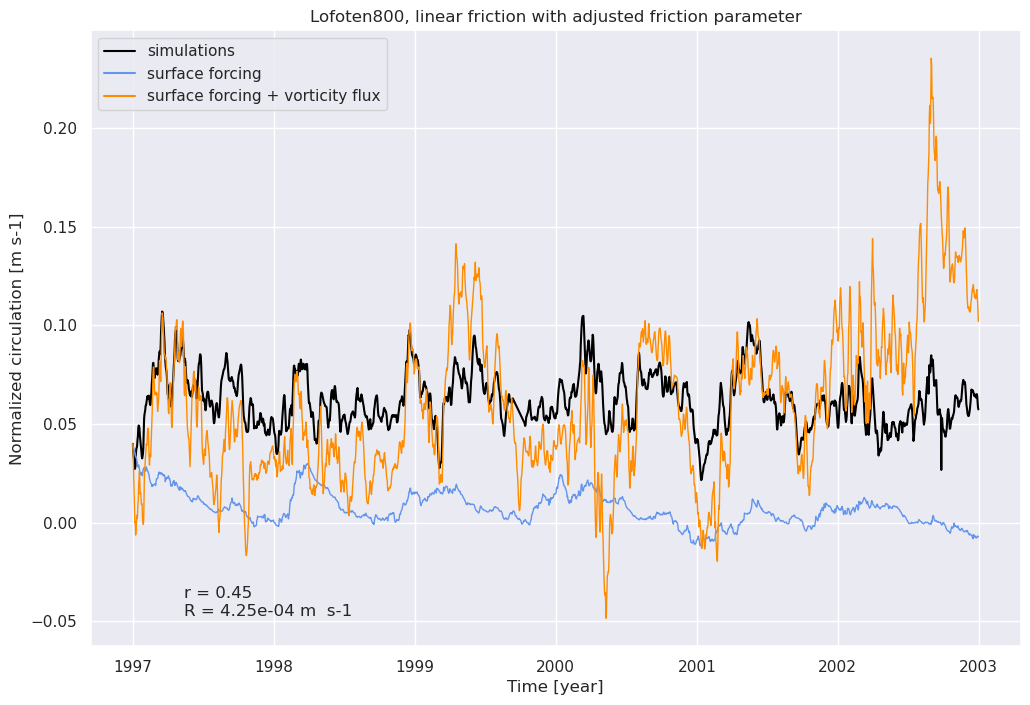

In [5]:
R = 10.6e-4
figL800, axL800, infoL800 = plot_integrals(ts_L800, friction="linear", 
                                 #R=R,
                                 adjustR=True,
                                 )
#axL800.set_title(f"Lofoten800, linear friction R = {R:.2e}")
axL800.set_title(f"Lofoten800, linear friction with adjusted friction parameter")

r = infoL800["r"]
R = infoL800["Rnod"]
axL800.text(0.1, 0.05, f"r = {r:.2f}\nR = {R:.2e} m  s-1", transform=axL800.transAxes)

figL800.savefig("figures/L800_time_integral_adjusted_R.pdf")
figL800.savefig("figures/L800_time_integral_adjusted_R.png")

Starting with the blue line, we see that including the surface forcing alone is not as sucsessfull in predicitng the circulation. The blue line seems to capture some of the variations in the simulations, but there is quite a big offset. 

Including vorticity fluxes reduces this offset (exept for some time steps), ant the correlation increases. Again, vorticity fluxes have a positive/cyclonic contribution.   

### Quadratic friction
We could also parametrize the friction as a quadratic function, which is closer to the friction in ROMS. We can't solve the problem analytically anymore then, but we can still solve it numerically.

We assume
$$
T_b = C_d^*|\overline{C}|\overline{C}
$$.
The circulation for the next time step can the be calculated as 
$$
\overline{C}_{i+1} = \overline{C}_{i} + dt*(F_i - C_d^*|\overline{C}|\overline{C})
$$


Again, we can ask what value we should use for $C_d^*$. Comparing with the bottom drag in ROMS, we have
$$
C_d^*|\overline{C}|\overline{C} = \oint \frac{C_d |u_b|\mathbf{u}_b}{H}\cdot d\mathbf{l}
$$ 
So,
$$
C_d^* = \oint \frac{C_d |u_b|\mathbf{u}_b}{H}\cdot d\mathbf{l} / (|\overline{C}|\overline{C}  )
$$

Let's plot $C_d^*$ for Arctic4 and Lofoten800:

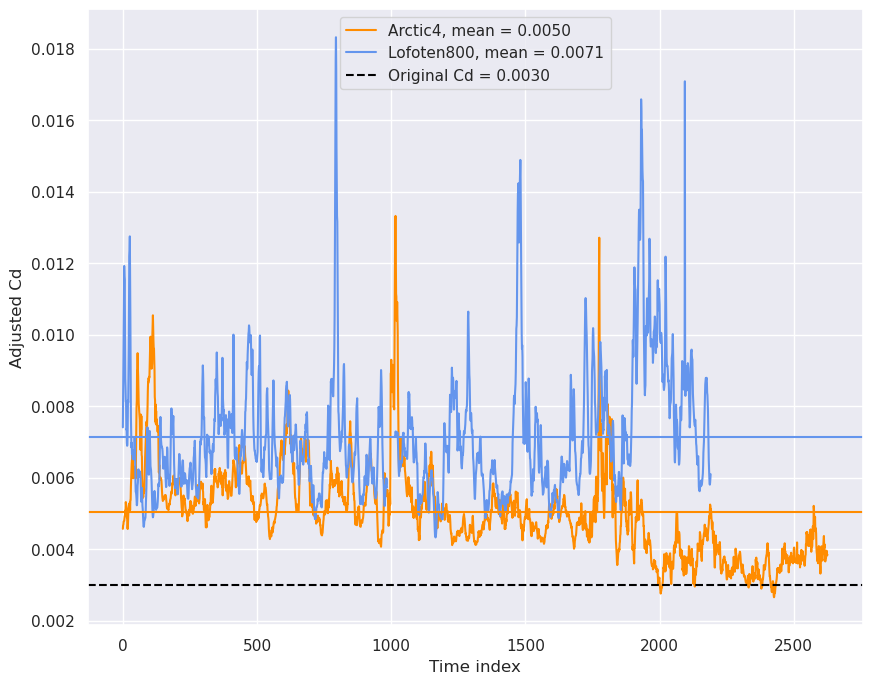

In [6]:
# Calculate the corrected drag coefficient (Cdnod) for each dataset
Cdnod_A4 = find_Cdnod(ts_A4, Cd)
Cdnod_L800 = find_Cdnod(ts_L800, Cd)

# calculate mean corrected drag coefficient
Cdnod_A4_mean = np.nanmean(Cdnod_A4)
Cdnod_L800_mean = np.nanmean(Cdnod_L800)

fig, ax = plt.subplots(figsize=(10,8))

# Plot the Cdnod for both datasets
ax.plot(Cdnod_A4, label=f'Arctic4, mean = {Cdnod_A4_mean:.4f}', color="darkorange")
ax.plot(Cdnod_L800, label=f'Lofoten800, mean = {Cdnod_L800_mean:.4f}', color="cornflowerblue")

# Add a horizontal line to represent the mean values
ax.axhline(Cdnod_A4_mean, color="darkorange")
ax.axhline(Cdnod_L800_mean, color="cornflowerblue")


# Add a horizontal line to represent the original drag coefficient Cd
ax.axhline(Cd, color='black', ls="--", label=f'Original Cd = {Cd:.4f}')

# Add labels and a legend for better clarity
ax.set_xlabel('Time index')
ax.set_ylabel('Adjusted Cd')
ax.legend()

fig.savefig("figures/adjustedCd.pdf")
fig.savefig("figures/adjustedCd.png")

We see that the value oscilliates around a mean value. Let's use these mean values together with a quadratic friction parametrization and calculate the resulting circulaitons. 

### Arctic4 quadratic friction

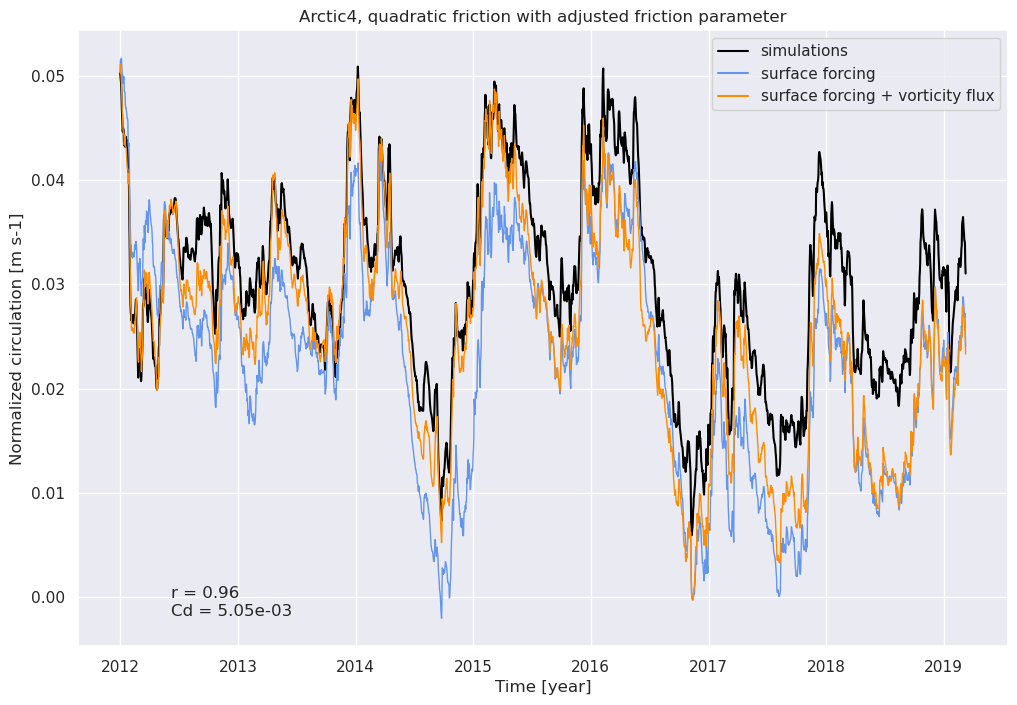

In [7]:
#figAf, axA4 = plot_integrals(ts_A4, friction="linear", R=5e-4);
figA4, axA4, infoA4 = plot_integrals(ts_A4, friction="quadratic", 
                             #adjustDc = False,
                             #dynamicDc=True,
                             )
axA4.set_title("Arctic4, quadratic friction with adjusted friction parameter")

r = infoA4["r"]
Cd = infoA4["Cdnod"]
axA4.text(0.1, 0.05, f"r = {r:.2f}\nCd = {Cd:.2e}", transform=axA4.transAxes)

figA4.savefig("figures/A4_time_integral_adjusted_Cd.pdf")
figA4.savefig("figures/A4_time_integral_adjusted_Cd.png")

We get quite similar results as for linear frictoin, but with a bit higher correaltion. 

### Lofoten800 quadratic friction

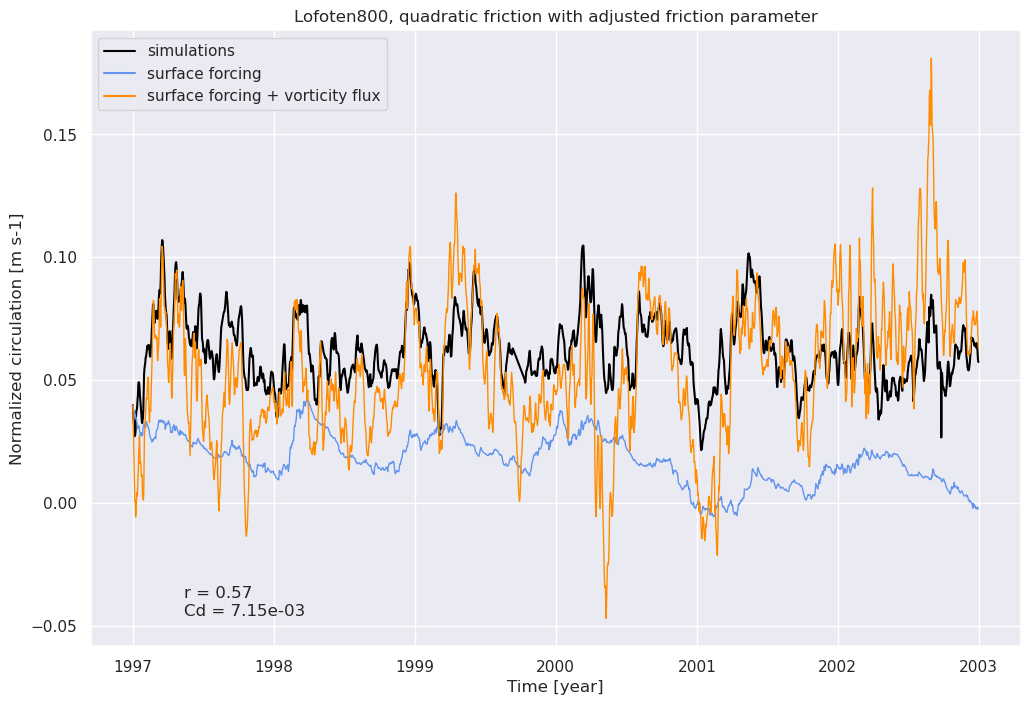

In [8]:
#figAf, axA4 = plot_integrals(ts_A4, friciton="linear", R=5e-4);
figL800, axL800, infoL800 = plot_integrals(ts_L800, friction="quadratic",
                                 #adjustDc = False,
                                 #dynamicDc=True
                                 )
axL800.set_title("Lofoten800, quadratic friction with adjusted friction parameter")

r = infoL800["r"]
Cd = infoL800["Cdnod"]
axL800.text(0.1, 0.05, f"r = {r:.2f}\nCd = {Cd:.2e}", transform=axL800.transAxes)

figL800.savefig("figures/L800_time_integral_adjusted_Cd.pdf")
figL800.savefig("figures/L800_time_integral_adjusted_Cd.png")

Correaltion increases from 0.45 to 0.57 going from linear to quadratic friction. 